## 3. 트랜스포머 (Transformer)와 어텐션 (Attention)

트랜스포머는 어텐션 메커니즘을 활용해 시퀀스 데이터를 병렬 처리할 수 있도록 설계된 모델

어텐션 메커니즘은 입력 데이터의 특정 부분에 더 집중해 학습할 수 있게 도와줌


In [ ]:
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### 3-1. 데이터 준비하기

먼저 입력 데이터를 트랜스포머에 넣기 위해 임베딩

이는 입력 토큰을 모델이 처리할 수 있는 벡터 형태로 변환하는 과정

In [ ]:
# 가상의 입력 데이터 (배치 크기=2, 시퀀스 길이=5, 단어 개수=10)
input_data = torch.randint(0, 10, (2, 5))  # 예시: [[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]]

# 임베딩 레이어 정의
embedding_dim = 8
embedding = nn.Embedding(10, embedding_dim)
embedded_input = embedding(input_data)
print("임베딩된 입력 크기:", embedded_input.shape)  # (배치 크기, 시퀀스 길이, 임베딩 차원)

임베딩된 입력 크기: torch.Size([2, 5, 8])


### 3-2. 포지셔널 인코딩 (Positional Encoding)

트랜스포머는 시퀀스 데이터에서 위치 정보를 인식하지 못하기 때문에, 포지셔널 인코딩을 사용해 위치 정보를 추가

이는 각 단어의 순서를 모델이 이해할 수 있도록 도움


In [ ]:
def positional_encoding(seq_len, embedding_dim):
    pos_encoding = torch.zeros(seq_len, embedding_dim)
    for pos in range(seq_len):
        for i in range(0, embedding_dim, 2):
            pos_encoding[pos, i] = math.sin(pos / (10000 ** ((2 * i) / embedding_dim)))
            pos_encoding[pos, i + 1] = math.cos(pos / (10000 ** ((2 * i) / embedding_dim)))
    return pos_encoding

# 포지셔널 인코딩 생성
seq_len = embedded_input.size(1)
pos_encoding = positional_encoding(seq_len, embedding_dim)
embedded_input += pos_encoding  # 위치 정보가 포함된 임베딩
print("포지셔널 인코딩 추가된 임베딩 크기:", embedded_input.shape)

포지셔널 인코딩 추가된 임베딩 크기: torch.Size([2, 5, 8])


### 3-3. Self-Attention 메커니즘 이해

Self-Attention은 각 단어가 다른 단어들과의 관계를 학습할 수 있도록 하는 과정

이를 위해 Query, Key, Value 벡터를 생성하고, Attention 점수를 계산해 각 단어의 중요도를 평가

In [ ]:
# Query, Key, Value를 생성하기 위한 차원 정의
query_dim = key_dim = value_dim = 8

# Query, Key, Value 레이어 정의
query_layer = nn.Linear(embedding_dim, query_dim)
key_layer = nn.Linear(embedding_dim, key_dim)
value_layer = nn.Linear(embedding_dim, value_dim)

# Query, Key, Value 생성
queries = query_layer(embedded_input)
keys = key_layer(embedded_input)
values = value_layer(embedded_input)

# Attention Score 계산 (점수에 softmax 적용)
attention_scores = torch.matmul(queries, keys.transpose(-2, -1)) / math.sqrt(embedding_dim)
attention_weights = torch.softmax(attention_scores, dim=-1)
attention_output = torch.matmul(attention_weights, values)

print("Self-Attention 출력 크기:", attention_output.shape)

Self-Attention 출력 크기: torch.Size([2, 5, 8])


### 4. Multi-Head Attention

Multi-Head Attention은 Self-Attention을 여러 번 수행하여 다양한 관계를 학습

이를 통해 모델이 다양한 패턴을 더 잘 학습

In [ ]:
# Multi-Head Attention 레이어 정의
multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=2, batch_first=True)
attn_output, attn_weights = multihead_attn(embedded_input, embedded_input, embedded_input)
print("Multi-Head Attention 출력 크기:", attn_output.shape)

Multi-Head Attention 출력 크기: torch.Size([2, 5, 8])


### 5. 트랜스포머 블록

트랜스포머의 기본 블록은 Multi-Head Attention, Add & Norm, Position-wise Feed-Forward Layers로 구성

이를 통해 모델은 각 시퀀스 내에서 중요한 정보에 집중하여 복잡한 관계를 학습

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads, hidden_dim):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim)
        )

    def forward(self, x):
        # Multi-Head Attention과 Add & Norm
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + attn_output)

        # Feed-Forward Layer와 Add & Norm
        ff_output = self.feed_forward(x)
        x = self.norm2(x + ff_output)
        return x

# 트랜스포머 블록 테스트
transformer_block = TransformerBlock(embedding_dim, num_heads=2, hidden_dim=16)
transformer_output = transformer_block(embedded_input)
print("트랜스포머 Block Output 크기:", transformer_output.shape)

트랜스포머 Block Output 크기: torch.Size([2, 5, 8])


### 3-6. 트랜스포머 인코더 및 전체 모델

트랜스포머 인코더는 여러 개의 트랜스포머 블록을 쌓아 모델의 성능을 강화

이를 통해 복잡한 패턴을 학습하고, 최종적으로 시퀀스 전체의 특성을 파악


In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim, num_heads, hidden_dim, num_layers):
        super(TransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([
            TransformerBlock(embedding_dim, num_heads, hidden_dim) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

# 트랜스포머 인코더 모델 생성 및 테스트
encoder = TransformerEncoder(embedding_dim, num_heads=2, hidden_dim=16, num_layers=3)
encoder_output = encoder(embedded_input)
print("트랜스포머 인코더 출력 크기:", encoder_output.shape)

트랜스포머 인코더 출력 크기: torch.Size([2, 5, 8])


### 7. 트랜스포머 모델의 어텐션 가중치 시각화

트랜스포머에서 학습된 어텐션 가중치를 시각화하여, 각 단어가 다른 단어들과 어떤 관계를 맺고 있는지 시각적으로 확인

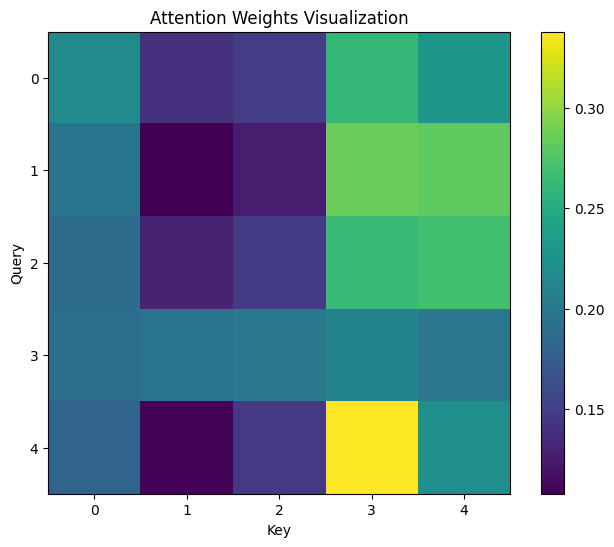

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(attn_weights[0].detach().cpu().numpy(), cmap="viridis")
plt.colorbar()
plt.title("Attention Weights Visualization")
plt.xlabel("Key")
plt.ylabel("Query")
plt.show()

## 3-7. 사전 학습된 트랜스포머 모델 불러오기 및 번역 실행

사전 학습된 트랜스포머 모델을 사용해 입력 텍스트를 번역

 여기서는 영어 텍스트를 다른 언어로 번역하는 작업을 수행하고, 모델 내부의 포지셔널 인코딩과 Attention 가중치를 시각화


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# T5 모델과 토크나이저 로드 (여기서는 영어-프랑스어 번역을 예시로 사용)
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# 번역할 텍스트 정의
text = "Translate English to French: How are you?"

# 입력 토큰 생성 및 번역 수행
input_ids = tokenizer.encode(text, return_tensors="pt")
decoder_input_ids = tokenizer.encode("<pad>", return_tensors="pt")
outputs = model.generate(input_ids, max_new_tokens=50, output_attentions=True, return_dict_in_generate=True)

# 번역 결과 디코딩
translated_text = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
print("번역 결과:", translated_text)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


번역 결과: Comment êtes-vous?


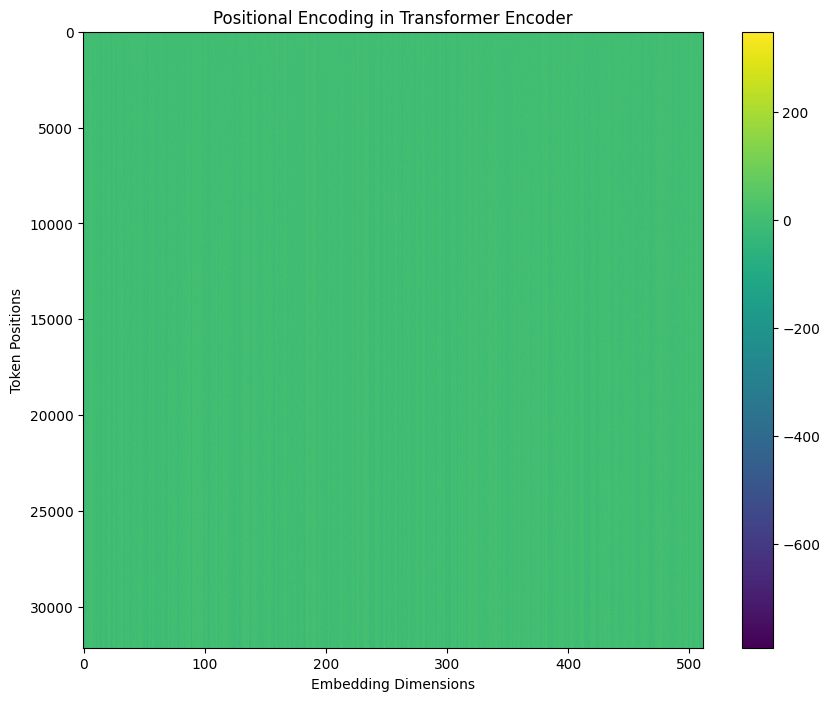

In [ ]:
# 포지셔널 인코딩 추출
pos_encoding = model.encoder.embed_tokens.weight.detach().cpu().numpy()

# 시각화
plt.figure(figsize=(10, 8))
plt.imshow(pos_encoding, cmap="viridis", aspect="auto")
plt.colorbar()
plt.title("Positional Encoding in Transformer Encoder")
plt.xlabel("Embedding Dimensions")
plt.ylabel("Token Positions")
plt.show()

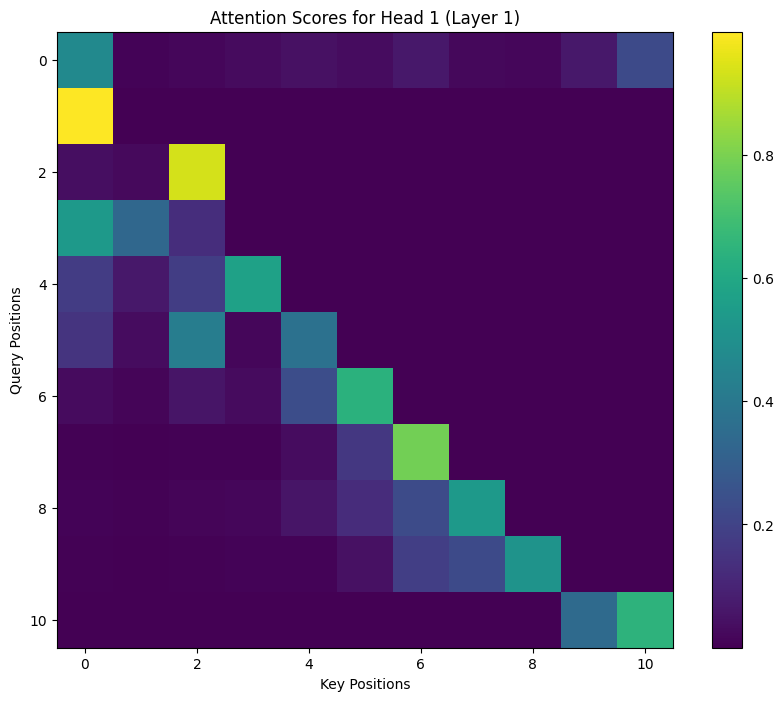

In [ ]:
# Attention 가중치 추출 (첫 번째 Attention 레이어의 첫 번째 Attention Head)
attentions = outputs.encoder_attentions
head_num = 0  # 첫 번째 Attention Head
attention_scores = attentions[0][0][head_num].detach().cpu().numpy()

# Attention 스코어 시각화
plt.figure(figsize=(10, 8))
plt.imshow(attention_scores, cmap="viridis")
plt.colorbar()
plt.title("Attention Scores for Head 1 (Layer 1)")
plt.xlabel("Key Positions")
plt.ylabel("Query Positions")
plt.show()

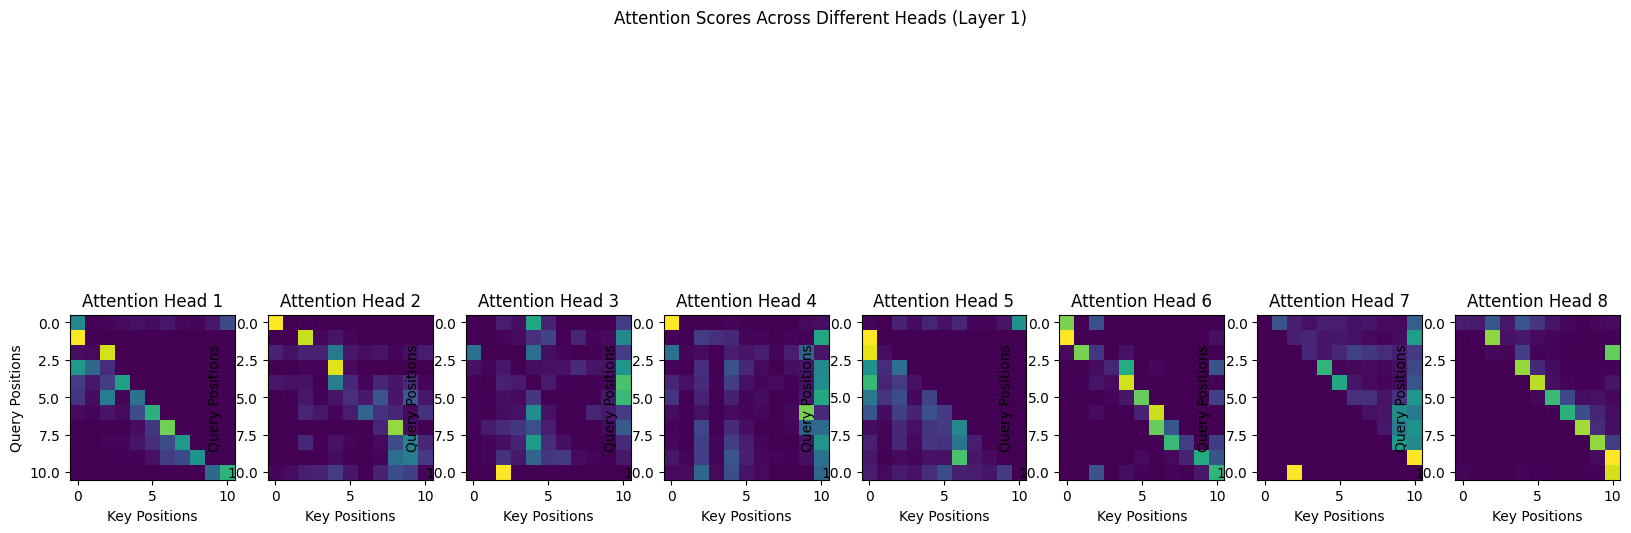

In [ ]:
num_heads = attentions[0][0].shape[0]  # 첫 번째 레이어의 헤드 개수
fig, axes = plt.subplots(1, num_heads, figsize=(20, 8))

for i in range(num_heads):
    attention_scores = attentions[0][0][i].detach().cpu().numpy()
    axes[i].imshow(attention_scores, cmap="viridis")
    axes[i].set_title(f"Attention Head {i+1}")
    axes[i].set_xlabel("Key Positions")
    axes[i].set_ylabel("Query Positions")

plt.suptitle("Attention Scores Across Different Heads (Layer 1)")
plt.show()

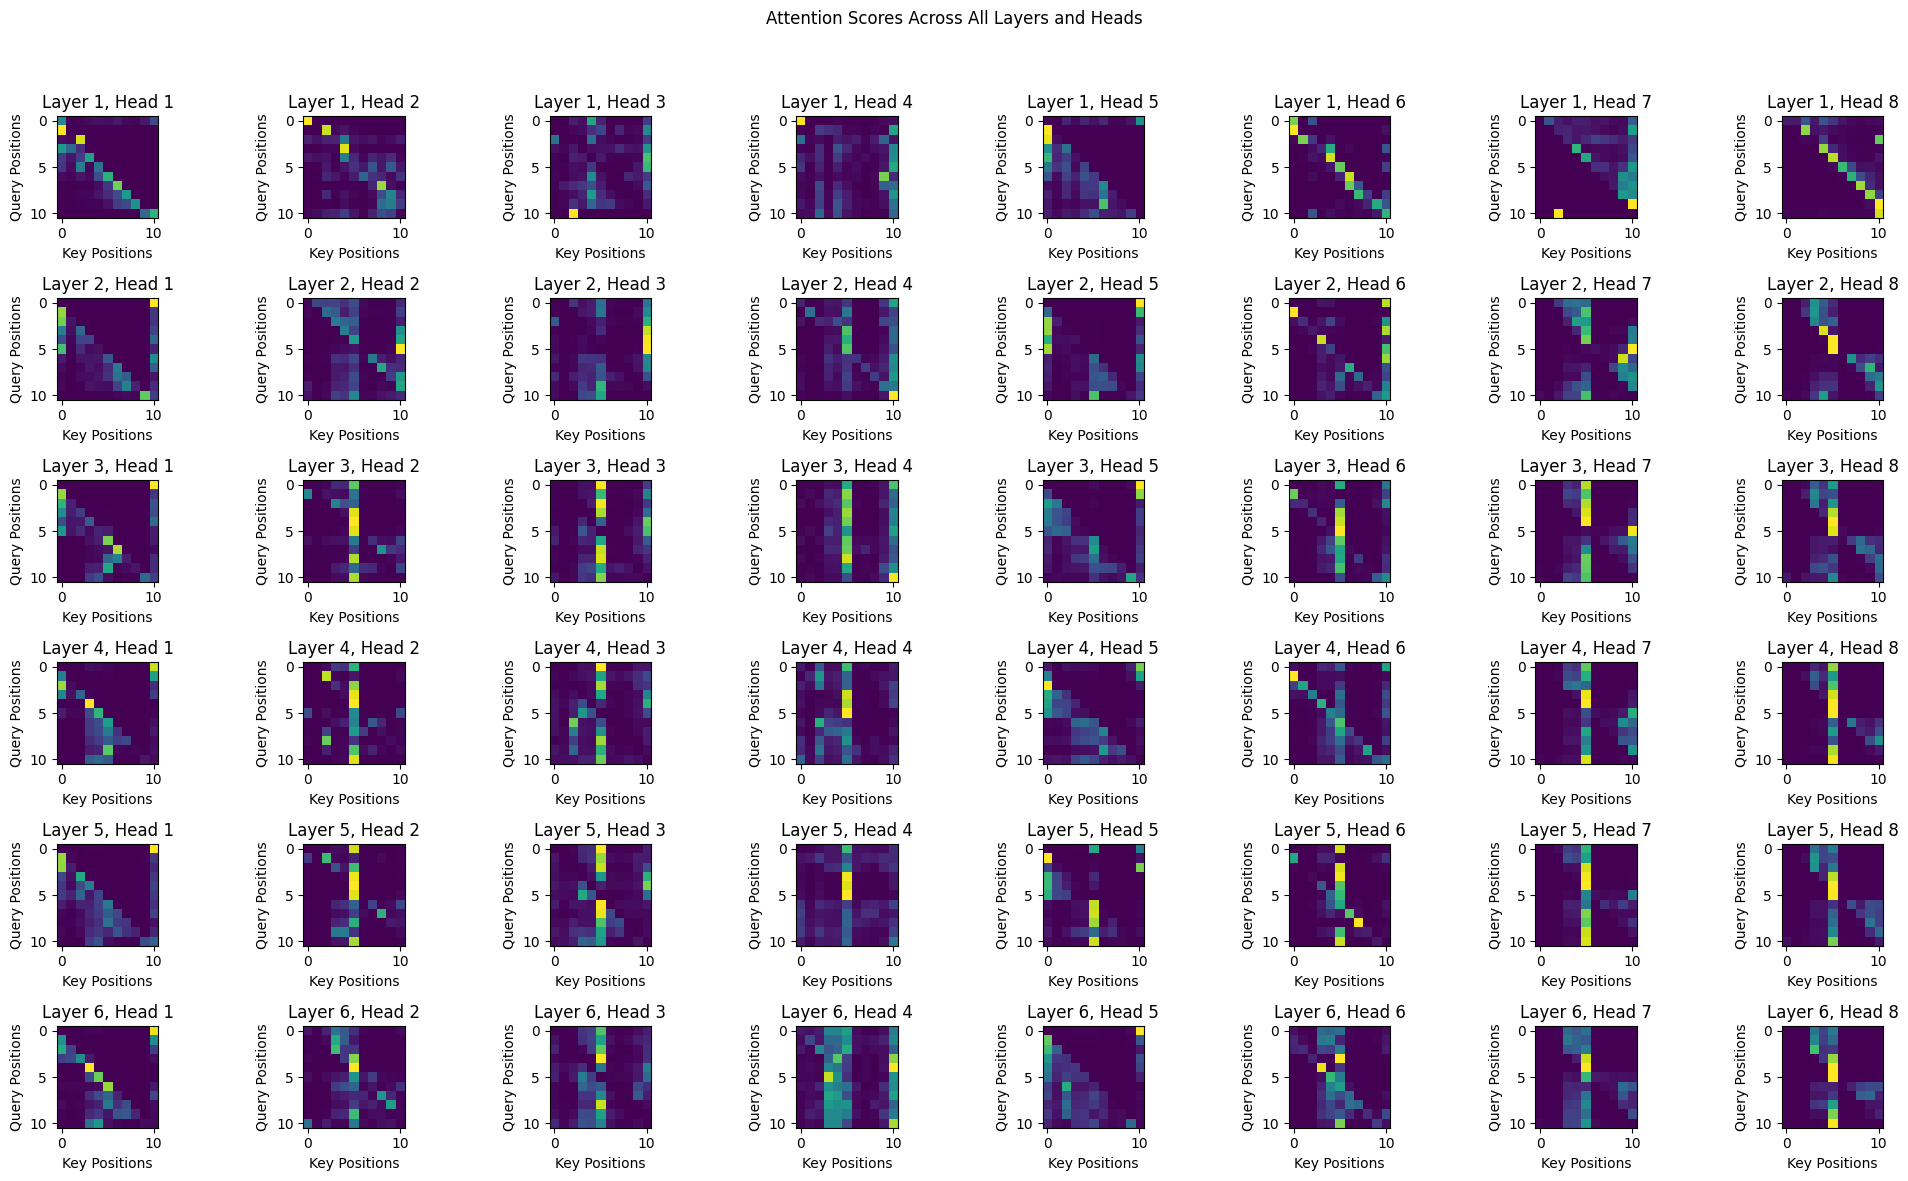

In [ ]:
num_layers = len(attentions)  # 전체 레이어 수
fig, axes = plt.subplots(num_layers, num_heads, figsize=(20, 2 * num_layers))

for layer in range(num_layers):
    for head in range(num_heads):
        attention_scores = attentions[layer][0][head].detach().cpu().numpy()
        axes[layer, head].imshow(attention_scores, cmap="viridis")
        axes[layer, head].set_title(f"Layer {layer+1}, Head {head+1}")
        axes[layer, head].set_xlabel("Key Positions")
        axes[layer, head].set_ylabel("Query Positions")

plt.suptitle("Attention Scores Across All Layers and Heads")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()